# LLM Interface
The `effectful.handlers.llm` module provides a simplified LLM interface that uses algebraic effects for modularity. The module interface consists of:

- A decorator `Template.define` which creates a prompt template from a callable. A template is an LLM-implemented function whose behavior is specified by a template string. When a template is called, an LLM is invoked to produce the specified behavior.
- A decorator `Tool.define` which exposes Python callables as tools that templates can call. Tool signatures and docstrings define the schema passed to the model.
- Structured output handling via `Encodable` (used internally by templates and tool calls) to serialize/deserialize Python types.
- LLM providers such as `LiteLLMProvider`, and reliability helpers like `RetryLLMHandler` and `ReplayLiteLLMProvider`, which can be composed with `handler(...)` to control execution.

In [1]:
import base64
import dataclasses
import functools
import io
from typing import Literal

import litellm
import pydantic
from IPython.display import HTML, display
from litellm.caching.caching import Cache
from PIL import Image
from pydantic import field_validator
from pydantic_core import PydanticCustomError

from effectful.handlers.llm import Template, Tool
from effectful.handlers.llm.completions import (
    LiteLLMProvider,
    RetryLLMHandler,
)
from effectful.ops.semantics import NotHandled, handler

provider = LiteLLMProvider()

In the following sections, we walk through each of the mentioned components.

## Prompt Templates

This template function writes (bad) poetry on a given theme. While difficult to implement in Python, an LLM can provide a reasonable implementation.

In [2]:
@Template.define
def limerick(theme: str) -> str:
    """Write a limerick on the theme of {theme}. Do not use any tools."""
    raise NotHandled

If we call the template with a provider interpretation installed, we get reasonable behavior. The LLM is nondeterministic by default, so calling the template twice with the same arguments gives us different results.

Templates are regular callables, so can be converted to operations with `defop` if we want to override the LLM implementation in some cases.

In [3]:
with handler(provider):
    print(limerick("fish"))
    print("-" * 40)
    print(limerick("fish"))

In the sea where the shimmering fish 
Dance around like a silvery wish,
They wiggle and glide,
With the tide, side by side,
Turning waves into their swirlish dish.
----------------------------------------
There once was a fish named Blue,
Who swam in a sea of bright hue.
With scales shining bright,
He'd dance in the light,
And none were as charming as Blue.


If we want deterministic behavior, we can cache the template call. We can either cache it with the default `@functools.cache` or use LiteLLM's built-in cache by setting a cache backend and passing `caching=True` to the provider:

In [4]:
@functools.cache
@Template.define
def haiku(theme: str) -> str:
    """Write a haiku on the theme of {theme}. Do not use any tools."""
    raise NotHandled


@Template.define
def haiku_no_cache(theme: str) -> str:
    """Write a haiku on the theme of {theme}. Do not use any tools."""
    raise NotHandled


print()
with handler(provider):
    print(haiku("fish"))
    print("-" * 40)
    print(haiku("fish"))

print()
# Enable LiteLLM caching by setting a cache backend and enabling caching.
litellm.cache = Cache()
provider_cached = LiteLLMProvider(caching=True)
try:
    with handler(provider_cached):
        print(haiku_no_cache("fish2"))
        print("-" * 40)
        print(haiku_no_cache("fish2"))
finally:
    litellm.cache = None

print()
with handler(provider):
    print(haiku_no_cache("fish3"))
    print("-" * 40)
    print(haiku_no_cache("fish3"))


Silent stream below,
Gleaming scales in dancing waves—
Fish glide through cool dreams.
----------------------------------------
Silent stream below,
Gleaming scales in dancing waves—
Fish glide through cool dreams.



/Users/nguyendat/Marc/effectful/.venv/lib/python3.12/site-packages/pydantic/main.py:528: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected 10 fields but got 6: Expected `Message` - serialized value may not be as expected [field_name='message', input_value=Message(content='{"value"...: None}, annotations=[]), input_type=Message])
  PydanticSerializationUnexpectedValue(Expected `StreamingChoices` - serialized value may not be as expected [field_name='choices', input_value=Choices(finish_reason='st...ider_specific_fields={}), input_type=Choices])
  return self.__pydantic_serializer__.to_json(


In streams not too deep,  
Silver swimmers glide below,  
Silent fins whisper.
----------------------------------------
Silvery fish dart,
Through the gentle stream they glide—
Nature's dance unfolds.

Fish beneath the waves,
Silent currents in their dance—
Nature's quiet grace.
----------------------------------------
In the whispering stream,
silver scales dance and shimmer—
a fleeting shadow.


## Converting LLM Results to Python Objects

Type conversion is handled by `decode`. By default, primitive types are converted. `DecodeError` is raised if a response cannot be converted.

In [5]:
@Template.define
def primes(first_digit: int) -> int:
    """Give a prime number with {first_digit} as the first digit. Do not use any tools."""
    raise NotHandled


with handler(provider):
    assert type(primes(6)) is int

More complex types can be converted by providing handlers for `decode`. Callable synthesis is supported via `Encodable` and the evaluation providers in `effectful.handlers.llm.evaluation` (`UnsafeEvalProvider` or `RestrictedEvalProvider`), which enable parsing/compiling/executing synthesized code.

In [6]:
import inspect
from collections.abc import Callable

from effectful.handlers.llm.evaluation import UnsafeEvalProvider


@Template.define
def count_char(char: str) -> Callable[[str], int]:
    """Write a function which takes a string and counts the occurrances of '{char}'. Do not use any tools."""
    raise NotHandled


# Use UnsafeEvalProvider for simple examples; RestrictedEvalProvider may need extra globals.
with handler(provider), handler(UnsafeEvalProvider()):
    count_a = count_char("a")
    assert callable(count_a)
    assert count_a("banana") == 3
    assert count_a("cherry") == 0
    # Print the source code of the generated function
    print(inspect.getsource(count_a))

def count_a(s: str) -> int:
    return s.count('a')


## Tool Calling

`Operation`s defined in the lexical scope of a `Template` are automatically available for the LLM to call as tools. The description of these operations is inferred from their type annotations and docstrings.

Tool calls are mediated by a helper operation `tool_call`. Handling this operation allows tool use to be tracked or logged.

In [7]:
@Tool.define
def cities() -> list[str]:
    """Return a list of cities that can be passed to `weather`."""
    return ["Chicago", "New York", "Barcelona"]


@Tool.define
def weather(city: str) -> str:
    """Given a city name, return a description of the weather in that city."""
    status = {"Chicago": "cold", "New York": "wet", "Barcelona": "sunny"}
    return status.get(city, "unknown")


@Template.define  # cities and weather auto-captured from lexical scope
def vacation() -> str:
    """Use the provided tools to suggest a city that has good weather. Use only the `cities` and `weather` tools provided."""
    raise NotHandled


with handler(provider):
    print(vacation())

Based on the weather descriptions:
- **Chicago**: Cold
- **New York**: Wet
- **Barcelona**: Sunny

I suggest Barcelona since it has sunny weather, which is generally considered good for most people.


## Image Inputs

You can pass `PIL.Image.Image` values directly to templates.


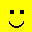

This is an image of a simple yellow smiley face with black eyes and a smile on a yellow background.


In [8]:
image_base64 = (
    "iVBORw0KGgoAAAANSUhEUgAAACAAAAAgCAYAAABzenr0AAAAhElEQVR4nO2W4QqA"
    "MAiEVXr/VzYWDGoMdk7Cgrt/sUs/DqZTd3EplFU2JwATYAJMoOlAB4bq89s95+Mg"
    "+gyAchsKAYplBBBA43hFhfxnUixDjdEUUL8hpr7R0KLdt9qElzcyiu8As+Kr8zQA"
    "mgLavAl+kIzFZyCRxtsAmWb/voZvqRzgBE1sIDuVFX4eAAAAAElFTkSuQmCC"
)
image = Image.open(io.BytesIO(base64.b64decode(image_base64)))


@Template.define
def describe_image(image: Image.Image) -> str:
    """Return a short description of the following image.
    {image}
    """
    raise NotHandled


with handler(provider):
    display(
        HTML(
            f'<img src="data:image/png;base64,{image_base64}" alt="Example image" width="320" />'
        )
    )
    print(describe_image(image))

## Structured Output Generation

Constrained generation is used for any type that is convertible to a Pydantic model.

In [9]:
@dataclasses.dataclass
class KnockKnockJoke:
    whos_there: str
    punchline: str


@Template.define
def write_joke(theme: str) -> KnockKnockJoke:
    """Write a knock-knock joke on the theme of {theme}. Do not use any tools."""
    raise NotHandled


@Template.define
def rate_joke(joke: KnockKnockJoke) -> bool:
    """Decide if {joke} is funny or not. Do not use any tools."""
    raise NotHandled


def do_comedy():
    joke = write_joke("lizards")
    print("> You are onstage at a comedy club. You tell the following joke:")
    print(
        f"Knock knock.\nWho's there?\n{joke.whos_there}.\n{joke.whos_there} who?\n{joke.punchline}"
    )
    if rate_joke(joke):
        print("> The crowd laughs politely.")
    else:
        print("> The crowd stares in stony silence.")


with handler(provider):
    do_comedy()

> You are onstage at a comedy club. You tell the following joke:
Knock knock.
Who's there?
Lizard.
Lizard who?
Lizard who? Lizard be a joke if I wasn't at your door!
> The crowd laughs politely.


## Template Composition

Templates defined in the lexical scope are also captured, enabling template composition. One template can use the result of another template in a pipeline:


In [10]:
# Sub-templates for different story styles
@Template.define
def story_with_moral(topic: str) -> str:
    """Write a short story about {topic} and end with a moral lesson. Do not use any tools."""
    raise NotHandled


@Template.define
def story_funny(topic: str) -> str:
    """Write a funny, humorous story about {topic}. Do not use any tools."""
    raise NotHandled


# Main orchestrator template - has access to sub-templates
@Template.define
def write_story(topic: str, style: str) -> str:
    """Write a story about {topic} in the style: {style}.
    Available styles: 'moral' for a story with a lesson, 'funny' for humor. Use story_funny for humor, story_with_moral for a story with a lesson."""
    raise NotHandled


# Verify sub-templates are captured in write_story's lexical context
assert story_with_moral in write_story.tools.values()
assert story_funny in write_story.tools.values()
print("Sub-templates available to write_story:", write_story.tools.keys())

with handler(provider):
    print("=== Story with moral ===")
    print(write_story("a curious cat", "moral"))
    print()
    print("=== Funny story ===")
    print(write_story("a curious cat", "funny"))

Sub-templates available to write_story: dict_keys(['limerick', 'haiku_no_cache', 'primes', 'count_char', 'cities', 'weather', 'vacation', 'describe_image', 'write_joke', 'rate_joke', 'story_with_moral', 'story_funny'])
=== Story with moral ===


---

=== Funny story ===


And so, Whiskers the curious cat continued to slink through life, tail high, always ready for another amusing escapade.


## Retrying LLM Requests
LLM calls can sometimes fail due to transient errors or produce invalid outputs. The `RetryLLMHandler` automatically retries failed template calls and can also surface tool/runtime errors as tool messages:

- `include_traceback`: When `True`, include traceback details in the error feedback (default: True)
- `catch_tool_errors`: Exception type(s) to catch during tool execution (default: `Exception`)
- `**kwargs`: Additional keyword arguments forwarded to `tenacity.Retrying` (defaults: `stop=stop_after_attempt(4)`, `wait=wait_none()`, `reraise=True`)


Example usage: having an unstable service that seldomly fail.

In [11]:
call_count = 0
REQUIRED_RETRIES = 3


@Tool.define
def unstable_service() -> str:
    """Fetch data from an unstable external service. May require retries."""
    global call_count
    call_count += 1
    if call_count < REQUIRED_RETRIES:
        raise ConnectionError(
            f"Service unavailable! Attempt {call_count}/{REQUIRED_RETRIES}. Please retry."
        )
    return "{ 'status': 'ok', 'data': [1, 2, 3] }"


@Template.define  # unstable_service auto-captured from lexical scope
def fetch_data() -> str:
    """Use the unstable_service tool to fetch data."""
    raise NotHandled


with handler(provider):
    try:
        result = fetch_data()
    except Exception as e:
        print(f"Error: {e}")

with handler(provider), handler(RetryLLMHandler()):
    result = fetch_data()
    print(f"Result: {result}", "Retries:", call_count)

Error: Tool execution failed: Error executing tool 'unstable_service': Service unavailable! Attempt 1/3. Please retry.
Result: The unstable service successfully returned the following data: `[1, 2, 3]`. Retries: 3


## Retrying with Validation Errors
As noted above, the `RetryHandler` can also be used to retry on runtime/validation error:

In [12]:
@pydantic.dataclasses.dataclass
class Rating:
    score: int
    explanation: str

    @field_validator("score")
    @classmethod
    def check_score(cls, v):
        if v < 1 or v > 5:
            raise PydanticCustomError(
                "invalid_score",
                "score must be 1–5, got {v}",
                {"v": v},
            )
        return v

    @field_validator("explanation")
    @classmethod
    def check_explanation_contains_score(cls, v, info):
        score = info.data.get("score", None)
        if score is not None and str(score) not in v:
            raise PydanticCustomError(
                "invalid_explanation",
                "explanation must mention the score {score}, got '{explanation}'",
                {"score": score, "explanation": v},
            )
        return v


@Template.define
def give_rating_for_movie(movie_name: str) -> Rating:
    """Give a rating for {movie_name}. The explanation MUST include the numeric score. Do not use any tools."""
    raise NotHandled


with handler(provider):
    try:
        rating = give_rating_for_movie("Die Hard")
    except Exception as e:
        print(f"Error: {e}")

with handler(provider), handler(RetryLLMHandler()):
    rating = give_rating_for_movie("Die Hard")
    print(f"Score: {rating.score}/5")
    print(f"Explanation: {rating.explanation}")

Error: Error decoding response: 1 validation error for Response
value.score
  score must be 1–5, got 9 [type=invalid_score, input_value=9, input_type=int]. Please provide a valid response and try again.
Score: 5/5
Explanation: Die Hard is a quintessential action film that has deeply influenced the genre. Its engaging storyline, memorable characters, and groundbreaking action scenes have made it a beloved classic. The film's humor and suspense balance combined with Bruce Willis' iconic performance contribute to its enduring appeal. It rightfully earns a top score of 5 out of 5 for its impact and entertainment value.


## Generating higher-order functions
Finally, we can generate higher-order functions that can call templates as well:

In [13]:
# Sub-templates for different story styles
@Template.define
def write_chapter(chapter_number: int, chapter_name: str) -> str:
    """Write a short story about {chapter_number}. Do not use any tools."""
    raise NotHandled


@Template.define
def judge_chapter(story_so_far: str, chapter_number: int) -> bool:
    """Decide if the new chapter is coherence with the story so far. Do not use any tools."""
    raise NotHandled


# Main orchestrator template - has access to sub-templates
@Template.define
def write_multi_chapter_story(style: Literal["moral", "funny"]) -> Callable[[str], str]:
    """Generate a function that writes a story in style: {style} about the given topic.

    If you raise exception, handle it yourself.
    The program can use helper functions defined elsewhere (DO NOT REDEFINE THEM):
    - write_chapter(chapter_number: int, chapter_name: str) -> str
    - judge_chapter(story_so_far: str, chapter_number: int) -> bool"""
    raise NotHandled


# Verify sub-templates are captured in write_story's lexical context
print("Sub-templates available to write_story:", write_multi_chapter_story.tools.keys())

with (
    handler(RetryLLMHandler()),
    handler(provider),
    handler(UnsafeEvalProvider()),
):
    print("=== Story with moral ===")
    function_that_writes_story = write_multi_chapter_story("moral")
    print(inspect.getsource(function_that_writes_story))
    print(function_that_writes_story("a curious cat"))
    print()

Sub-templates available to write_story: dict_keys(['limerick', 'haiku_no_cache', 'primes', 'count_char', 'cities', 'weather', 'vacation', 'describe_image', 'write_joke', 'rate_joke', 'story_with_moral', 'story_funny', 'write_story', 'unstable_service', 'fetch_data', 'give_rating_for_movie', 'write_chapter', 'judge_chapter'])
=== Story with moral ===
def generate_moral_story(topic: str) -> str:
    story_so_far = ""
    chapter_number = 1
    chapter_name_prefix = "Chapter"
    
    while True:
        try:
            chapter_name = f"{chapter_name_prefix} {chapter_number}"
            chapter = write_chapter(chapter_number, chapter_name)
            if judge_chapter(story_so_far, chapter_number):
                story_so_far += chapter + "\n"
                chapter_number += 1
                
                # For the purpose of the demonstration, let's stop after 3 chapters
                if chapter_number > 3:
                    break
            else:
                # If the c